# Predictiong and Analysis of Inflation

Hi,

My name is Leon, and this is my Analysis of inflation project.

In the project below I am going to analyze relationship between different inflation metrics, as well as predict price inflation.  

In the older days, the definition of inflation was increase of monetary supply, which devalues the currency.  
However in modern days by inflation what is meant usually in increase in prices, which also means devaluation of the currency, but in a different way.  

For the monetary supply index I will use M1 for this notebook.  
For the price index I will use CPI index,

In the nootebook below I am going to analyze the relationship between M1 and CPI as well as those indices individually.  

The final goal of the notebook is to build a model to predict CPI inflation index by data including the M1.

**Important note**  
There is a serious data drift in last 2 years due to covid,  
This notebook is focused on data prior to 2020 events.

## Data description

### Monetary supply

There are various indices for measuring how much money exists in the economy:  
M0, M1, M2, M3, M4  
Basically the difference between them is what is considered as money in the index and what is not,  
For example M0 index is used to measure the amount of all banknotes and coins, and M1 adds checkable deposits (a type of credit) on top of that.  
each subsequent index includes more asset classes on top of what the previous one includes.  
More information on the indices:  
https://www.wallstreetmojo.com/money-supply/

All the data is available on the [Federal Reserve website](https://fred.stlouisfed.org/).  
We'll use the following dataset as it is not adjusted to inflation:  
https://fred.stlouisfed.org/series/M1NS 

### Prices increases

For the data for increases in prices we'll choose CPI (Consumer Price Index),  
It is calculated by the [U.S. BUREAU OF LABOR STATISTICS](https://www.bls.gov/).  
In short, it measures the cost of various specific goods that are consumed by everyday people.
Although this index is far from perfect for many reasons,  
It is still the most common index of prices inflation.  
More information on the CPI and how it is measured:  
https://www.investopedia.com/terms/c/consumerpriceindex.asp   

The data can be downloaded from the BLS website:  
https://www.bls.gov/cpi/data.htm

### Glossary - important acronyms

**YoY** - Year-over-Year - means how the certain feature has changed compared to what it was exactly a year ago  
**MoM** - Month-over-Month - same concept as YoY, shows how the feature has changed compared a month ago  
**CPI** - Consumer Price Index (mentioned above) - measures increases in prices (price inflation)  
**M1, M2** - (mentioned above) different metrics to measure how much money is in the monetary system (monetary inflation)  

Please note that in this notebook we look at YoY and MoM as changes in percents, and not in raw values.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import datetime

# Model packages
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

# preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings

# Evaluation
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

from random import seed
warnings.filterwarnings('ignore')

## Loading datasets

The data is very small, as each dataset consists of just a single datapoint for every month for several decades.  
So all the data was already downloaded and saved locally to small excel files in this repository.

### CPI

Source: [BLS](https://data.bls.gov/PDQWeb/ap)

In [2]:
df_cpi_raw = pd.read_excel('cpi data.xlsx', skiprows=11)

In [3]:
df_cpi_raw.sample(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
64,1977.0,58.5,59.1,59.5,60.0,60.3,60.7,61.0,61.2,61.4,61.6,61.9,62.1,NaN,NaN
58,1971.0,39.8,39.9,40.0,40.1,40.3,40.6,40.7,40.8,40.8,40.9,40.9,41.1,NaN,NaN
89,2002.0,177.1,177.8,178.8,179.8,179.8,179.9,180.1,180.7,181.0,181.3,181.3,180.9,178.9,180.9


### M1

In [4]:
df_m1_raw = pd.read_excel('M1NS.xls', skiprows=10)

In [5]:
df_m1_raw.sample(3)

,observation_date,M1NS
56,1963-09-01,151.0
205,1976-02-01,285.3
736,2020-05-01,16170.7


### M2

In [6]:
df_m2_raw = pd.read_excel('M2NS.xls', skiprows=10)

In [7]:
df_m2_raw.sample(3)

,observation_date,M2NS
696,2017-01-01,13281.6
511,2001-08-01,5225.0
361,1989-02-01,2982.6


Looks like M1 and M2 data dataset are already stored in convenient Time Series format,  
But We'll need to transform the CPI data to match the other datasets.

## Checking Data integrity

### CPI

In [8]:
df_cpi_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    110 non-null    float64
 1   Jan     110 non-null    float64
 2   Feb     110 non-null    float64
 3   Mar     110 non-null    float64
 4   Apr     110 non-null    float64
 5   May     110 non-null    float64
 6   Jun     110 non-null    float64
 7   Jul     110 non-null    float64
 8   Aug     110 non-null    float64
 9   Sep     109 non-null    float64
 10  Oct     109 non-null    float64
 11  Nov     109 non-null    float64
 12  Dec     109 non-null    float64
 13  HALF1   39 non-null     float64
 14  HALF2   38 non-null     float64
dtypes: float64(15)
memory usage: 13.0 KB


In [9]:
df_cpi_raw.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1913.0,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,NaN,NaN
1,1914.0,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,NaN,NaN
2,1915.0,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,NaN,NaN
3,1916.0,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,NaN,NaN
4,1917.0,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,NaN,NaN


We see 2 definetely excess columns here: HALF1, HALF2.  
Better get rid of them now.

In [10]:
df_cpi_raw = df_cpi_raw.drop(["HALF1", "HALF2"], axis=1)

### M1

In [11]:
df_m1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  764 non-null    datetime64[ns]
 1   M1NS              764 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB


In [12]:
df_m1_raw.head(10)

,observation_date,M1NS
0,1959-01-01,142.2
1,1959-02-01,139.3
2,1959-03-01,138.4
3,1959-04-01,139.7
4,1959-05-01,138.7
5,1959-06-01,139.4
6,1959-07-01,140.3
7,1959-08-01,140.0
8,1959-09-01,140.3
9,1959-10-01,140.7


In [13]:
df_m1_raw.shape

(764, 2)

The data here is already in the format I want to be, so there won't be much of data transformation on this dataframe.

In [14]:
df_m1_raw = df_m1_raw.rename(columns={
    'observation_date' : 'month',
    'M1NS' : 'M1'})

In [15]:
df_m2_raw.sample(3)

,observation_date,M2NS
1,1959-02-01,287.7
137,1970-06-01,597.5
721,2019-02-01,14401.9


In [16]:
df_m2_raw = df_m2_raw.rename(columns={
    'observation_date' : 'month',
    'M2NS' : 'M2'})

## Preprocessing

### Merging tables

We'll join data from all the datasets into a single dataframe called df_inflation

In [17]:
df_inflation = df_m1_raw.copy()

In [18]:
df_inflation.sample(5)

,month,M1
742,2020-11-01,17642.4
95,1966-12-01,176.9
404,1992-09-01,982.7
68,1964-09-01,157.8
195,1975-04-01,277.7


Let's transform the CPI dataframe to the same format as the M1 dataframe

In [19]:
df_cpi_raw = df_cpi_raw.melt(id_vars=["Year"]).sort_values(by="Year")

In [20]:
df_cpi_raw.head(5)

,Year,variable,value
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8


I'll just rename month to a normal feature name,
I call it **month_raw** as I want to use month afterwards for the full month format

In [21]:
df_cpi_raw = df_cpi_raw.rename(columns={
    'variable' : 'month_raw',
    'value' : 'CPI'})

In [22]:
df_cpi_raw.head(5)

,Year,month_raw,CPI
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8


In [23]:
df_cpi_raw['Year'] = df_cpi_raw['Year'].astype('int')

In [24]:
df_cpi_raw['month'] = pd.to_datetime(df_cpi_raw['month_raw'] + ' ' + df_cpi_raw['Year'].astype('str'))

In [25]:
df_cpi_raw = df_cpi_raw.sort_values(by='month')

Now we can add the CPI and M2 values as well to our dataframe.

In [26]:
df_inflation = df_inflation.merge(df_cpi_raw, on="month", how="outer")

In [27]:
df_inflation = df_inflation.merge(df_m2_raw, on="month", how="outer")

In [28]:
df_inflation.sample(3)

,month,M1,Year,month_raw,CPI,M2
1248,1953-05-01,NaN,1953,May,26.700,NaN
626,2011-03-01,1909.4,2011,Mar,223.467,9000.6
21,1960-10-01,141.2,1960,Oct,29.800,309.9


In [29]:
df_inflation = df_inflation.sort_values(by='month').reset_index(drop=True)

### Adding Features

In [30]:
def add_pct_change_and_sma_per_timeframe_to_df(period_name, period_length):
    df_inflation['cpi_' + period_name] = df_inflation['CPI'].pct_change(periods=period_length)
    df_inflation['m1_' + period_name] = df_inflation['M1'].pct_change(period_length)
    df_inflation['m2_' + period_name] = df_inflation['M2'].pct_change(period_length)
    df_inflation['cpi_' + period_name + '_sma'] = df_inflation['cpi_' + period_name].dropna().rolling(15).mean()
    df_inflation['m1_' + period_name + '_sma'] = df_inflation['m1_' + period_name].dropna().rolling(15).mean()
    df_inflation['m2_' + period_name + '_sma'] = df_inflation['m2_' + period_name].dropna().rolling(15).mean()

In [31]:
add_pct_change_and_sma_per_timeframe_to_df('MoM', 1)

In [32]:
add_pct_change_and_sma_per_timeframe_to_df('quarterly', 3)

In [33]:
add_pct_change_and_sma_per_timeframe_to_df('half_year', 6)

In [34]:
add_pct_change_and_sma_per_timeframe_to_df('YoY', 12)

### Choosing a timeframe to work on

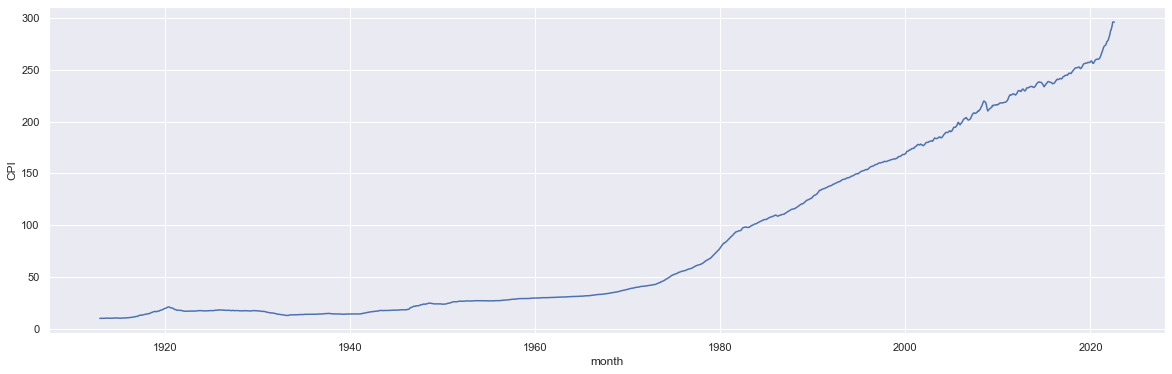

In [35]:
sns.set(rc = {'figure.figsize':(20,6)})
sns.lineplot(data=df_inflation, x="month", y="CPI")
plt.show()

In [36]:
def plot_pct_changes_of_inflation(df, period_name, metric, show_sma=True, feature_full_column_name=None):
    # Init the plot
    sns.set(rc = {'figure.figsize':(20,8)})
    fig, ax = plt.subplots(1, 1)
    
    # feature_column_name feature is used when you feed a raw column name in the df instead of the metric that has several columns with names derivated from the metric's name
    # so if feature_column_name is passed in parameters we most probably won't find an SMA with the name as calculated below
    show_sma = False if feature_full_column_name is not None else show_sma
    feature_full_column_name = metric + "_" + period_name if feature_full_column_name is None else feature_full_column_name
    # sns.lineplot(data=df, x="month", y=metric + "_" + period_name + "_change", ax=ax, legend='auto')
    sns.lineplot(data=df, x="month", y=feature_full_column_name, ax=ax, legend='auto')
    if show_sma:
        sns.lineplot(data=df, x="month", y=metric + "_" + period_name + "_sma", ax=ax, legend='auto')
    ax.set(title=metric.upper() + " " + period_name + " change")
    ylabels = ['{:,.2%}'.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    
    # adding the legend
    legend_labels_list = [period_name.capitalize() + " " + metric.upper() + " change"]
    if show_sma:
        legend_labels_list.append("SMA: " + period_name.capitalize() + " " + metric.upper() +" change")
    plt.legend(labels=legend_labels_list)
    plt.show()

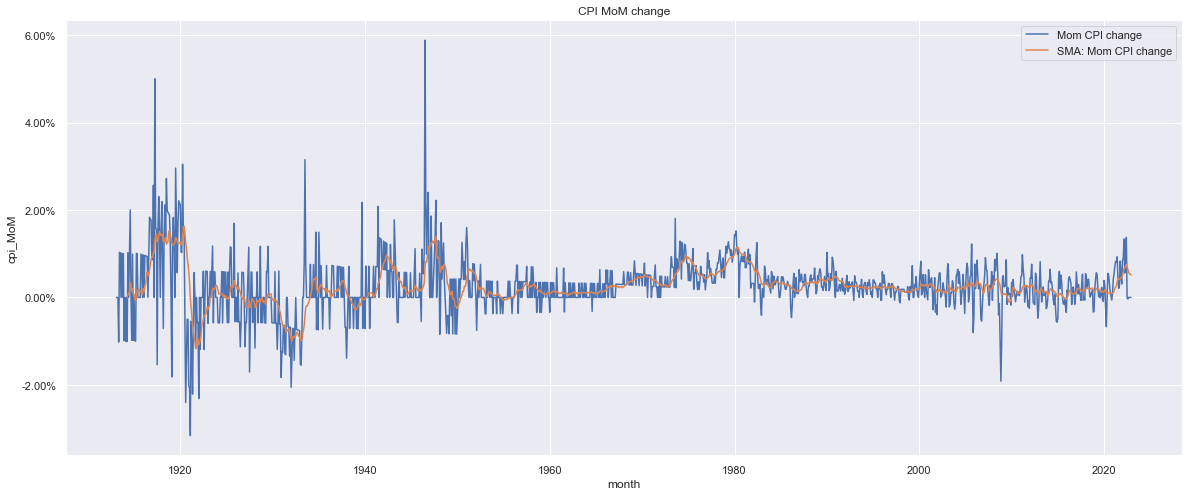

In [37]:
plot_pct_changes_of_inflation(df_inflation, "MoM", "cpi")

The data looks very noisy amd it looks like the seasonality is way different in the 60th than in the last 3 decades.  
Also there are many differences in monetary concepts between now and then.  
I think it would be wiser to look at a shorter timeframe, say let's take a look at the data starting from 1996, so it's approximately 2.5 decades before today.  

In [38]:
df_inflation_last_decades = df_inflation.query('month > "Jan 1994"')

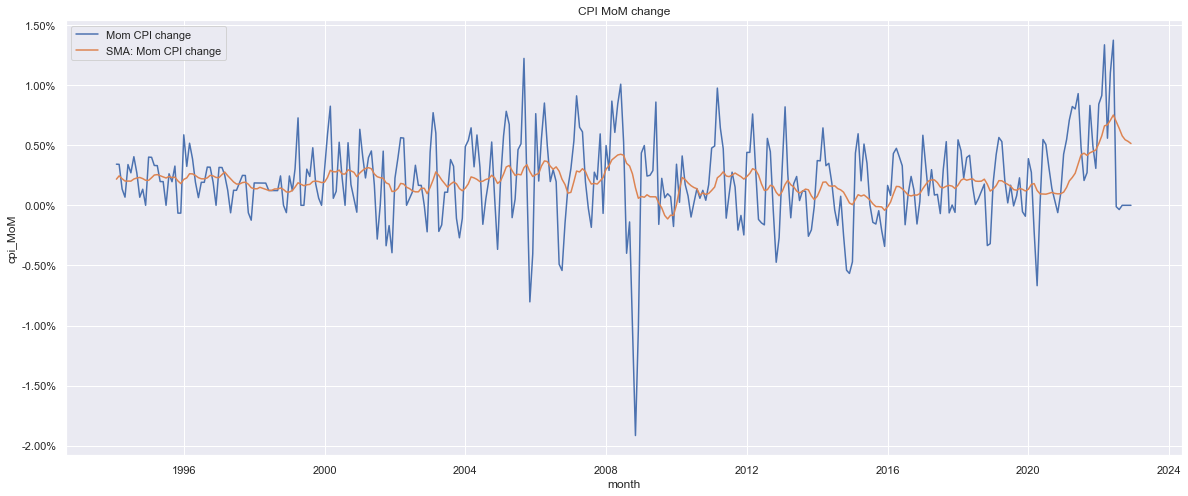

In [39]:
plot_pct_changes_of_inflation(df_inflation_last_decades, "MoM", "cpi")

Looks better, but we still have a huge outlier upward trend since 2020 events.  

Let's also look as the regular CPI plot, and not only it's changes

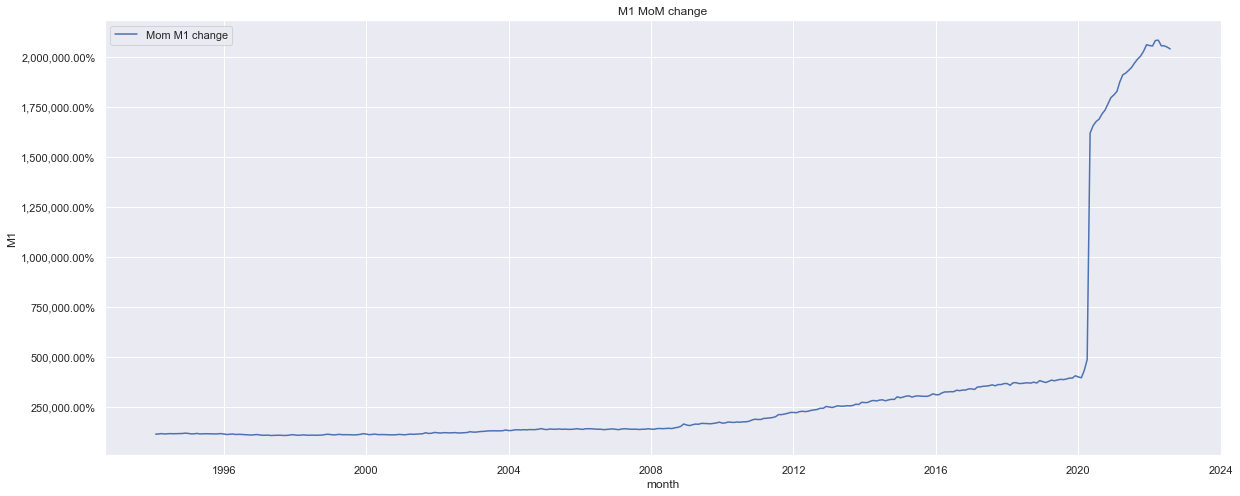

In [40]:
plot_pct_changes_of_inflation(df_inflation_last_decades, "MoM", "m1", feature_full_column_name='M1')

We have a live example here of an extreme data drift.  
Unfortunately there is no enough orior data of such drastic shifts and how it affected the financial situation,  
so this notebook won't be focused on addressing the latest shift, but rather analyzing and making predictions on past data.

In [41]:
df_inflation_last_decades = df_inflation_last_decades.query('month < "2020-03-01"')

**Conclusion**  
We filtered the data to analyze to data between 1994-2020.  

## EDA

### CPI

#### Plot

Let's look at plots both at monthly change level and yearly change level.  
You can also uncomment the lines below to plot changes per quarter and half a year, but it doesn't add up a lot of insightful info.

In [42]:
list_periods = ['MoM', 
                # 'quarterly', 
                # 'half_year', 
                'YoY']

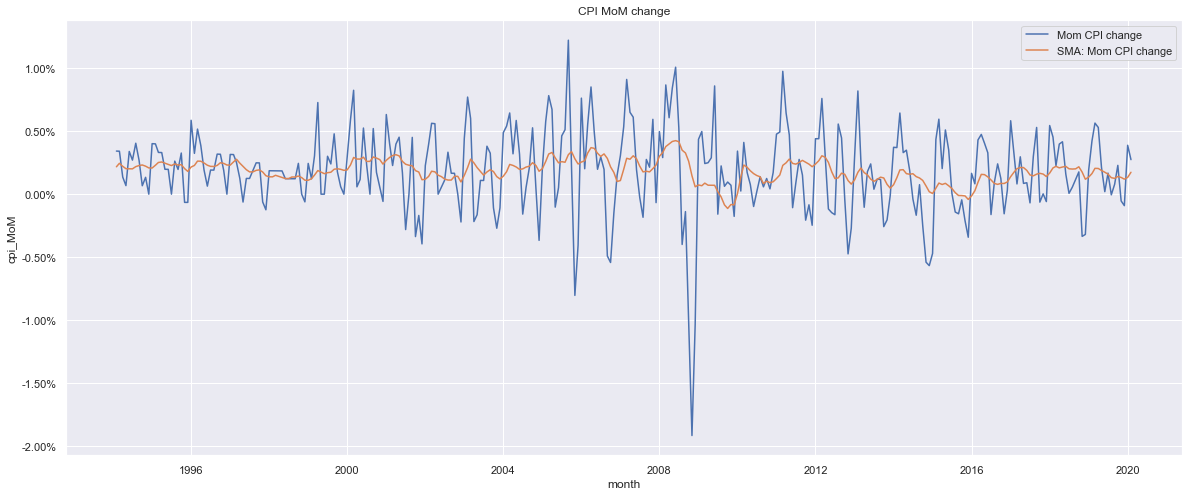

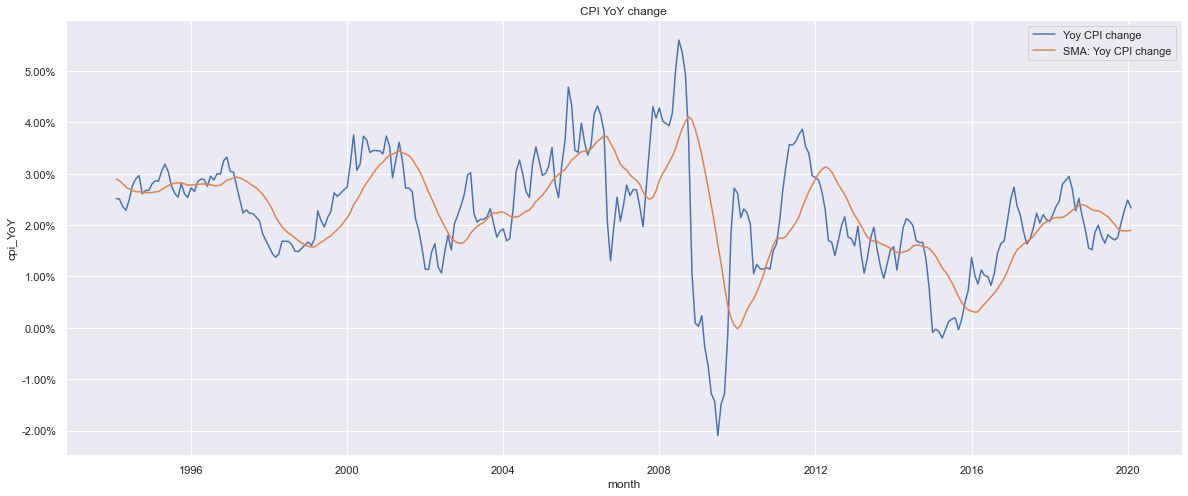

In [43]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'cpi')

#### Insights
 * The YoY plot shows data similar to MoM plot but less noisy, and we can see more long term trends on the YoY plot.  
   Same goes with the M1 and M2 plots, so we'll skip the MoM plots for now.
 * The prices inflation on average at most of the times was higher than 2% (official yearly target of the Federal Reserve)

### M1

#### Plot

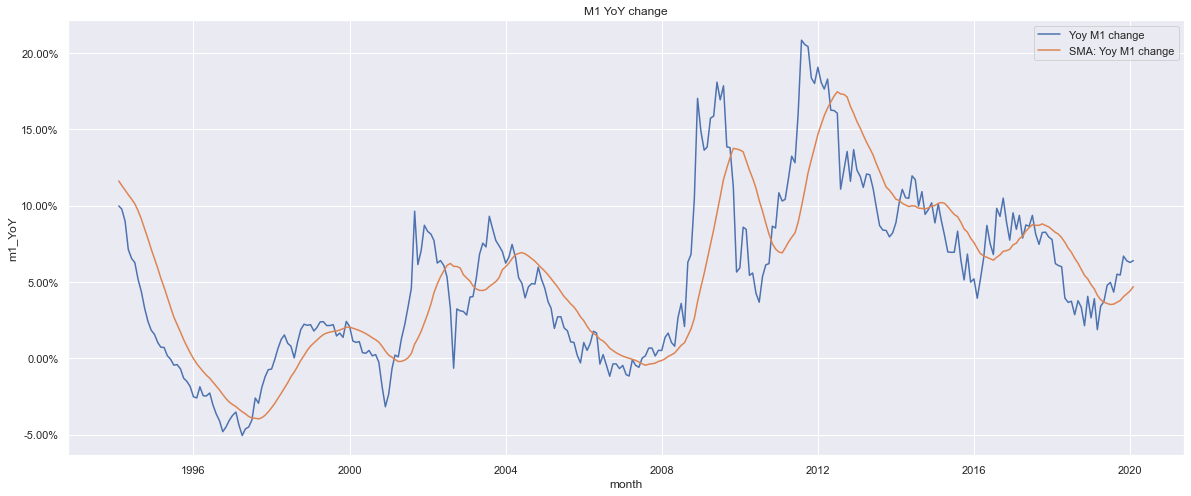

In [44]:
plot_pct_changes_of_inflation(df_inflation_last_decades, 'YoY', 'm1')

#### Insights
* prior to 2008 the average increase in monetary supply was varying between 0%-5%, sometimes even negative
* Since 2009 the monetary inflation got higher and almost never got below 5%
* The increase since 2009 is mostly due to [QE (Quantitative Easing)](https://www.investopedia.com/terms/q/quantitative-easing.asp)

### M2

#### Plot

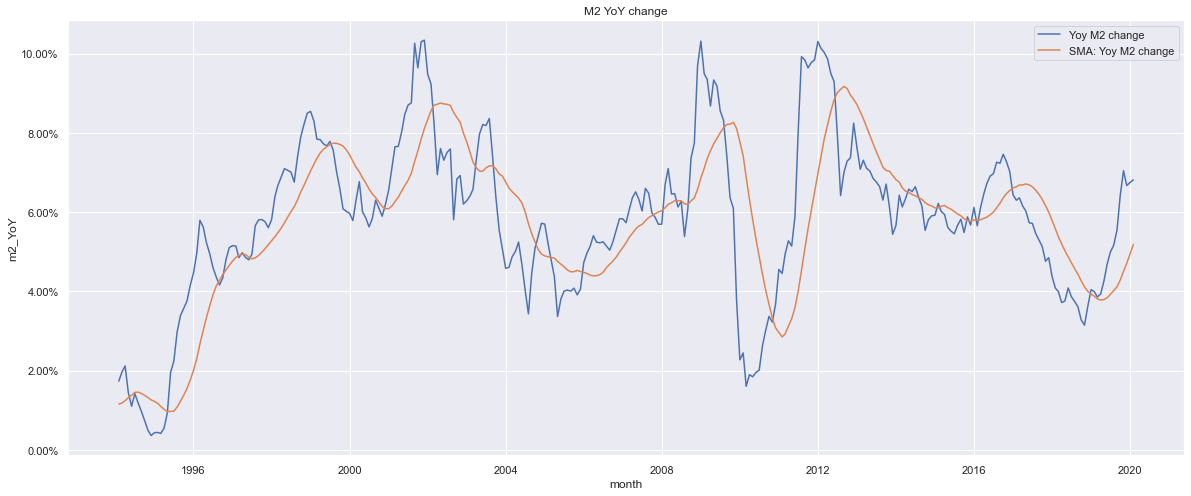

In [45]:
plot_pct_changes_of_inflation(df_inflation_last_decades, 'YoY', 'm2')

#### Insights
The plots behave in a similar way to the M1 once.  
Makes sense as M2 includes all the information of M1 plus more items included.

### Distribution

Now after we looked at the change as a line plot, lets also see the distributions of inflation change

#### CPI, M1, M2 appreciation values

<AxesSubplot:xlabel='cpi_MoM', ylabel='Density'>

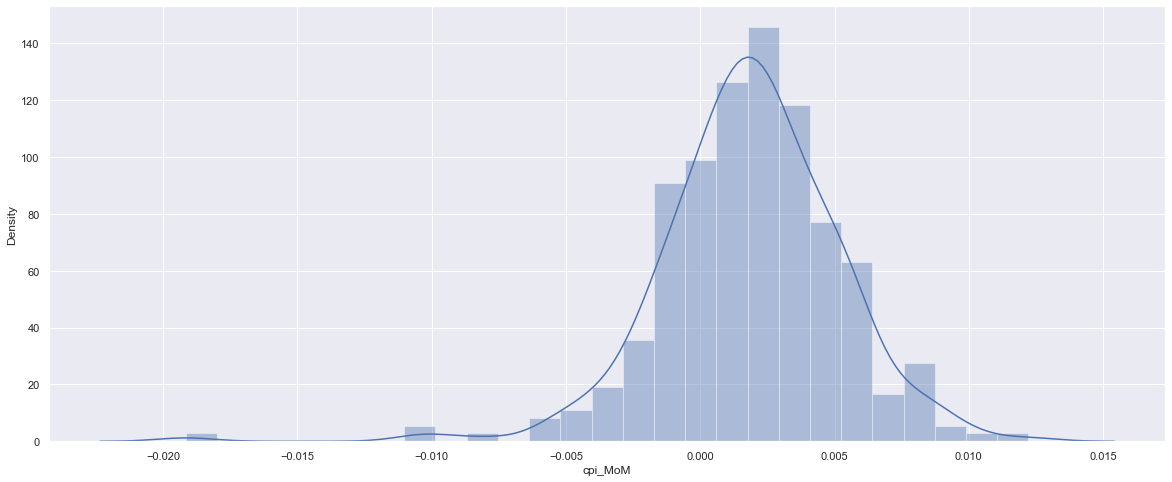

In [46]:
sns.distplot(df_inflation_last_decades['cpi_MoM'])

<AxesSubplot:xlabel='cpi_YoY', ylabel='Density'>

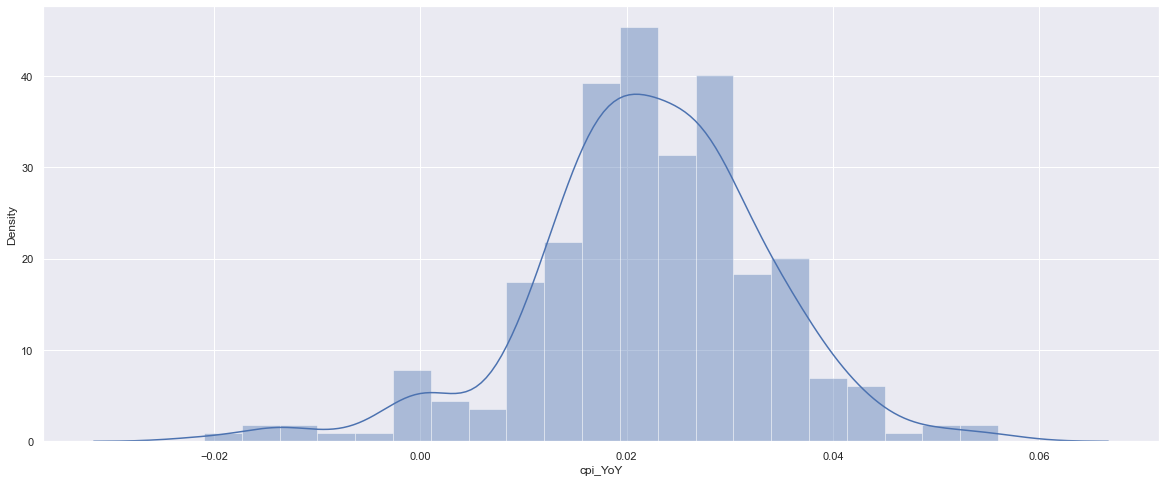

In [47]:
sns.distplot(df_inflation_last_decades['cpi_YoY'])

In [48]:
df_inflation_last_decades['cpi_YoY'].describe()

count    313.000000
mean       0.022263
std        0.011257
min       -0.020972
25%        0.016360
50%        0.022293
75%        0.029006
max        0.056001
Name: cpi_YoY, dtype: float64

In [49]:
(1+df_inflation_last_decades['cpi_YoY'].mean())**20

1.5532898835267512

#### Monthly breakdown

In [50]:
months_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

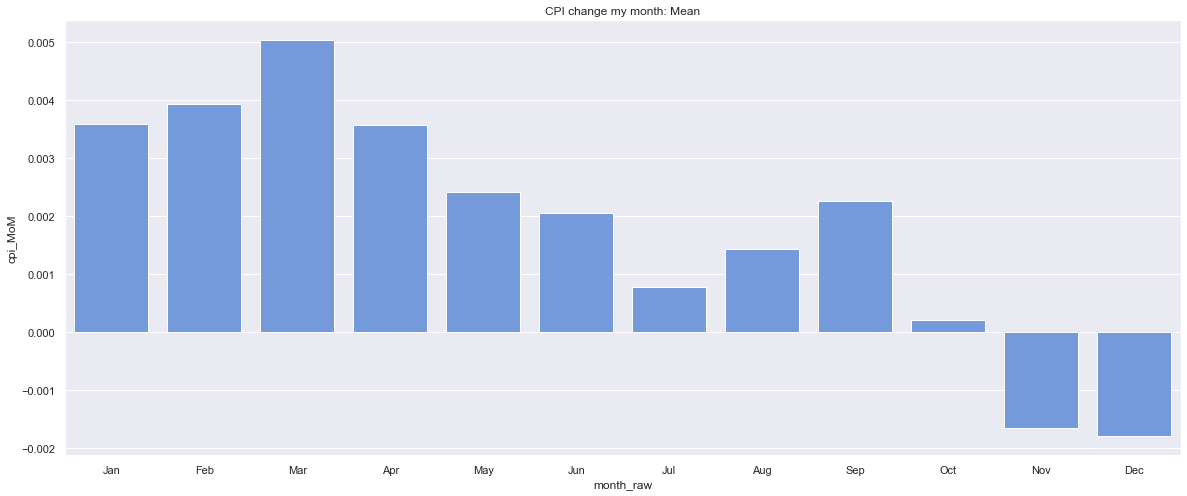

In [51]:
df_temp = df_inflation_last_decades.groupby('month_raw').agg({"cpi_MoM" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
ax = sns.barplot(data=df_temp, x='month_raw', y='cpi_MoM', color='cornflowerblue')
ax.set(title='CPI change my month: Mean')
plt.show()

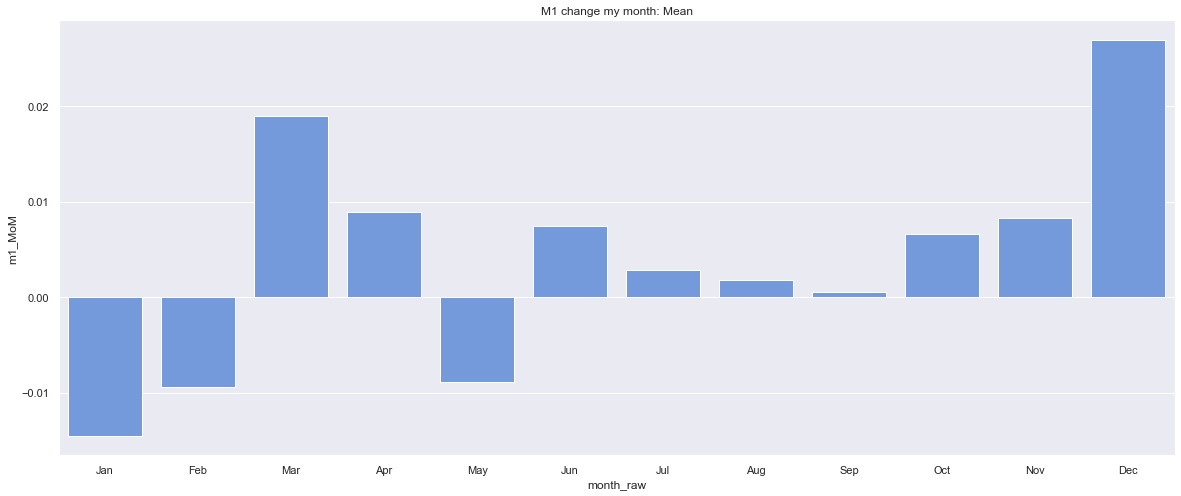

In [52]:
df_temp = df_inflation_last_decades.groupby('month_raw').agg({"m1_MoM" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
ax = sns.barplot(data=df_temp, x='month_raw', y='m1_MoM', color='cornflowerblue')
ax.set(title='M1 change my month: Mean')
plt.show()

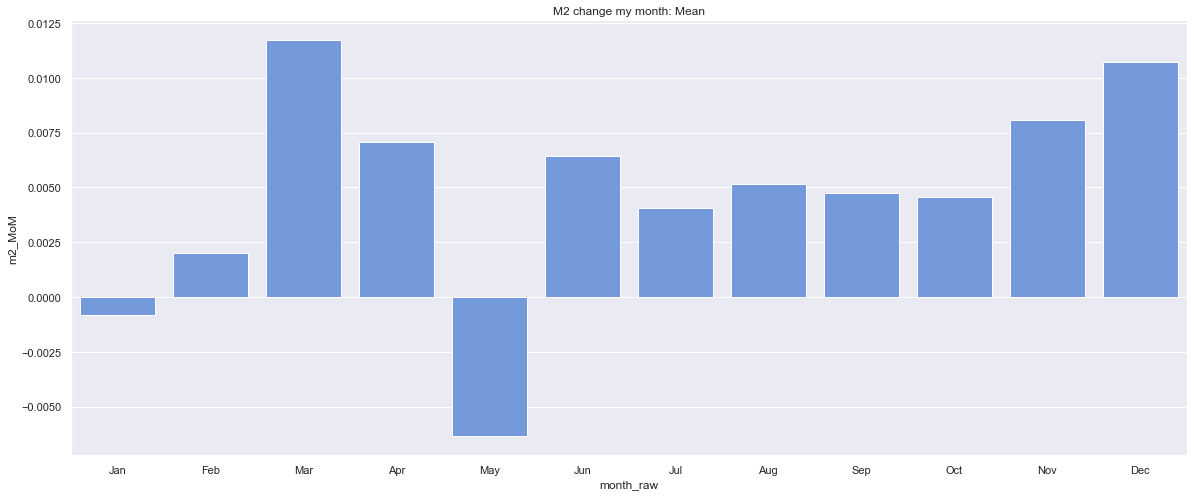

In [53]:
df_temp = df_inflation_last_decades.groupby('month_raw').agg({"m2_MoM" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
ax = sns.barplot(data=df_temp, x='month_raw', y='m2_MoM', color='cornflowerblue')
ax.set(title='M2 change my month: Mean')
plt.show()

In [54]:
# df_temp

### Relationship between the inflation metrics

Now let's divide out dataset to train and test, and then continue analyzing just the train set to avoid target leakage on the model engineering process

In [55]:
df_inflation_time_train = df_inflation.query('month >= "Jan 1994" and month <= "Jan 2012"')

Now let's explore graphically the relation between CPI and M1 change.  
As the pct_change data is very noisy by it's nature,  
I'll compare the Simple Moving Average of both metrics.

In [56]:
def plot_pct_change_sma_of_2_features(df, feature1, feature2, title=None,
                                      feature1_column=None, feature2_column=None):
    feature1_column = feature1 + '_YoY_sma' if feature1_column is None else feature1_column
    feature2_column = feature2 + '_YoY_sma' if feature2_column is None else feature2_column
    title = feature1.upper() + " and " + feature2.upper() + " change (SMA) side by side" if title is None else title
    sns.set(rc = {'figure.figsize':(20,10)})
    fig, axes = plt.subplots(1, 1)
    ax=axes
    sns.lineplot(data=df, x="month", y=feature1_column)
    sns.lineplot(data=df, x="month", y=feature2_column)
    ax.set(title=title)
    ylabels = ['{:,.2%}'.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    plt.legend(labels=[feature1.upper() , feature2.upper()])
    plt.show()

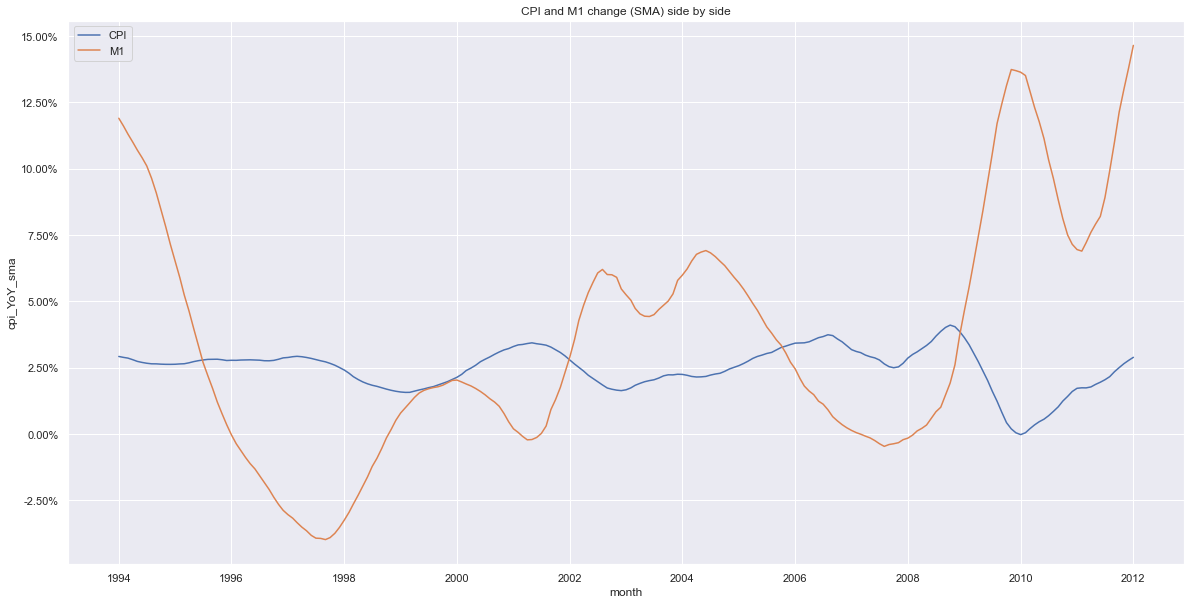

In [57]:
plot_pct_change_sma_of_2_features(df_inflation_time_train, 'cpi', 'm1')

If we look closely we may see that is several instances the trend of the CPI follows the trend of M1 with a 2 year lag.  
Let's take a closer look by plotting a lagged version of M1.

let's extract the 2 year lag feature and add it to our df

In [58]:
df_inflation_time_train['m1_YoY_shift'] = df_inflation_time_train['m1_YoY'].shift(24) * 0.2
df_inflation_time_train['m1_YoY_sma_shift'] = df_inflation_time_train['m1_YoY_sma'].shift(24)*0.25

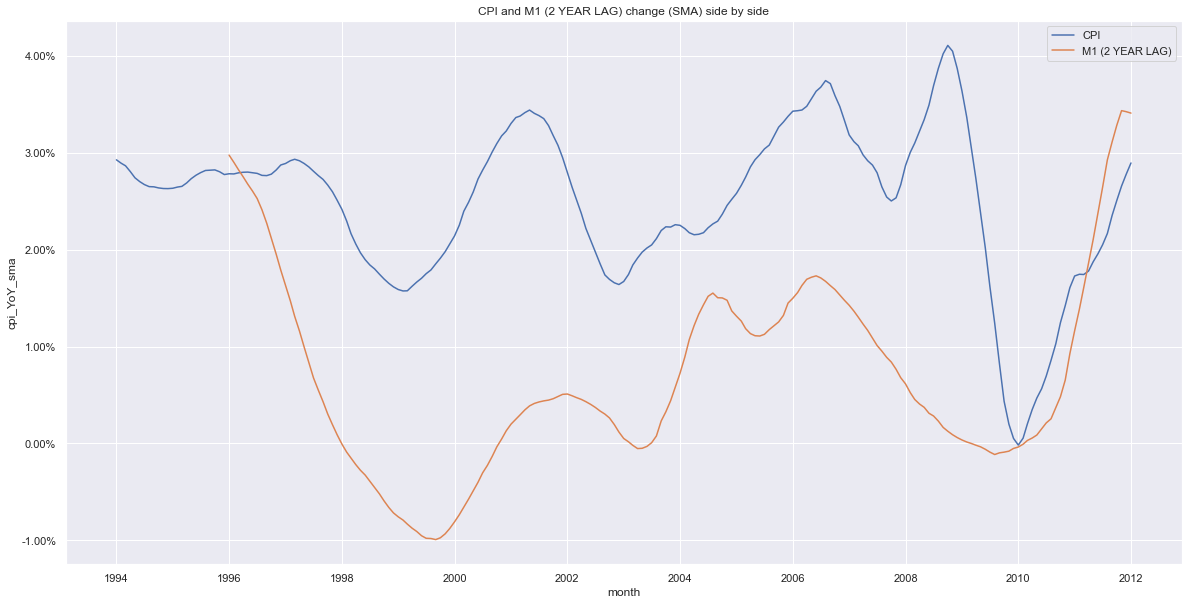

In [59]:
plot_pct_change_sma_of_2_features(df_inflation_time_train, 'cpi', 'm1 (2 year lag)', feature2_column='m1_YoY_sma_shift')

We can see visually that change in CPI is strongly correlated to change in M1 two years prior

Let's see the actual pearson correlation

In [60]:
df_inflation_time_train.corr()['cpi_YoY_sma']['m1_YoY_sma_shift']

0.33359907636433056

While linearry the correlation is weaker than expected, graphically we see heavy correlation.  
It makes sense, since if we look at the plot we see that the relation between the 2 lines is not linear,  
However we can see the following insights:
* Mostly the 2 features go in the same direction
* There is a correlation between how impactful a single uptrend or downtrend is in the 2 features
* The lag is usually around 2 years, but it also can vary from time to time
* In most instances if the plot both lines go in the same direction

## Feature engineering

First let's decide what our target is.  
As the rule of thumb the CPI only increases and not necessary lineary, as well as usually after a large spike it doesn't bounce back to where it was, it would be difficult to predict the CPI itself.  
However, we can predict how much it would increase.

so our target will be the next cpi_yearly_change

In [61]:
df_inflation['target'] = df_inflation['cpi_MoM'].shift(-1)

In [62]:
df_inflation = df_inflation.dropna()

In [63]:
df_inflation['month_num'] = df_inflation['month'].dt.month

In [64]:
df_inflation = df_inflation.set_index('month')

In [65]:
df_inflation = df_inflation.drop(['Year', 'month_raw'], axis=1)

In [66]:
df_inflation

,M1,CPI,M2,cpi_MoM,m1_MoM,m2_MoM,cpi_MoM_sma,m1_MoM_sma,m2_MoM_sma,cpi_quarterly,...,m1_half_year_sma,m2_half_year_sma,cpi_YoY,m1_YoY,m2_YoY,cpi_YoY_sma,m1_YoY_sma,m2_YoY_sma,target,month_num
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,140.6,29.800,317.2,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.004076,0.023856,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3
1961-04-01,142.4,29.800,320.2,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.003217,0.024464,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4
1961-05-01,140.6,29.800,320.0,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.002516,0.025403,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5
1961-06-01,141.2,29.800,322.7,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.001849,0.026495,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6
1961-07-01,141.5,30.000,324.9,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.000939,0.027285,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,20817.8,289.109,21860.3,0.005583,0.000812,0.000206,0.006697,0.009451,0.008110,0.028316,...,0.067510,0.057051,0.082586,0.090765,0.078456,0.058044,0.779073,0.142411,0.011024,4
2022-05-01,20537.9,292.296,21590.4,0.011024,-0.013445,-0.012347,0.007067,0.007897,0.006764,0.030242,...,0.062889,0.053466,0.085815,0.071367,0.062541,0.062648,0.541628,0.128635,0.013736,5
2022-06-01,20535.4,296.311,21645.0,0.013736,-0.000122,0.002529,0.007510,0.006218,0.005490,0.030633,...,0.056544,0.048374,0.090598,0.063437,0.058917,0.066941,0.321594,0.116411,-0.000118,6


In [67]:
df_inflation['m1_YoY_shift'] = df_inflation['m1_YoY'].shift(24)
df_inflation['m1_YoY_sma_shift'] = df_inflation['m1_YoY_sma'].shift(24)

In [68]:
df_inflation = df_inflation[:-10]

In [69]:
df_inflation

,M1,CPI,M2,cpi_MoM,m1_MoM,m2_MoM,cpi_MoM_sma,m1_MoM_sma,m2_MoM_sma,cpi_quarterly,...,cpi_YoY,m1_YoY,m2_YoY,cpi_YoY_sma,m1_YoY_sma,m2_YoY_sma,target,month_num,m1_YoY_shift,m1_YoY_sma_shift
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,140.6,29.800,317.2,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3,NaN,NaN
1961-04-01,142.4,29.800,320.2,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4,NaN,NaN
1961-05-01,140.6,29.800,320.0,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5,NaN,NaN
1961-06-01,141.2,29.800,322.7,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6,NaN,NaN
1961-07-01,141.5,30.000,324.9,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,19310.4,271.696,20440.7,0.009291,0.007334,0.005960,0.003433,0.176196,0.016346,0.025744,...,0.053915,0.167179,0.129090,0.019145,2.743747,0.218225,0.004811,6,0.047777,0.035843
2021-07-01,19459.4,273.003,20571.9,0.004811,0.007716,0.006419,0.004199,0.167984,0.012429,0.022276,...,0.053655,0.162005,0.127054,0.022503,2.736630,0.215392,0.002066,7,0.049664,0.035161
2021-08-01,19683.7,273.567,20778.0,0.002066,0.011527,0.010019,0.004336,0.013211,0.010507,0.016241,...,0.052513,0.166849,0.134220,0.025925,2.530072,0.209740,0.002716,8,0.043296,0.035420


### Logorithmic transformation
As some features are growing exponentially (e.g. CPI, M1),  
it would be wiser to apply a log function to the feature, as linear models work less well with exponential data

In [70]:
df_inflation['M1'] = np.log(df_inflation['M1'])
df_inflation['M2'] = np.log(df_inflation['M2'])
df_inflation['CPI'] = np.log(df_inflation['CPI'])

In [71]:
df_inflation

,M1,CPI,M2,cpi_MoM,m1_MoM,m2_MoM,cpi_MoM_sma,m1_MoM_sma,m2_MoM_sma,cpi_quarterly,...,cpi_YoY,m1_YoY,m2_YoY,cpi_YoY_sma,m1_YoY_sma,m2_YoY_sma,target,month_num,m1_YoY_shift,m1_YoY_sma_shift
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,4.945919,3.394508,5.759532,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3,NaN,NaN
1961-04-01,4.958640,3.394508,5.768946,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4,NaN,NaN
1961-05-01,4.945919,3.394508,5.768321,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5,NaN,NaN
1961-06-01,4.950177,3.394508,5.776723,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6,NaN,NaN
1961-07-01,4.952300,3.401197,5.783517,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,9.868399,5.604684,9.925283,0.009291,0.007334,0.005960,0.003433,0.176196,0.016346,0.025744,...,0.053915,0.167179,0.129090,0.019145,2.743747,0.218225,0.004811,6,0.047777,0.035843
2021-07-01,9.876086,5.609483,9.931681,0.004811,0.007716,0.006419,0.004199,0.167984,0.012429,0.022276,...,0.053655,0.162005,0.127054,0.022503,2.736630,0.215392,0.002066,7,0.049664,0.035161
2021-08-01,9.887546,5.611547,9.941650,0.002066,0.011527,0.010019,0.004336,0.013211,0.010507,0.016241,...,0.052513,0.166849,0.134220,0.025925,2.530072,0.209740,0.002716,8,0.043296,0.035420


## Train-test split

In [72]:
df_train = df_inflation.query('month > "1963-03-01" and month < "2016-11-01"')

In [73]:
df_test = df_inflation.query('month > "2016-11-01" and month < "2020-02-01"')

In [74]:
X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

In [75]:
y_train = df_train['target']
y_test = df_test['target']

## Model Training

### Baseline

In [76]:
model_linreg = LinearRegression()

In [77]:
model_linreg.fit(X_train, y_train)

LinearRegression()

In [78]:
model_linreg.score(X_test, y_test)

0.08373058257419008

In [79]:
y_pred_linreg = model_linreg.predict(X_test)

In [80]:
print('Baseline results:')
print('-----------------')
print('RMSE: {:.2%}'.format(mean_squared_error(y_pred_linreg, y_test, squared=False)))

Baseline results:
-----------------
RMSE: 0.22%


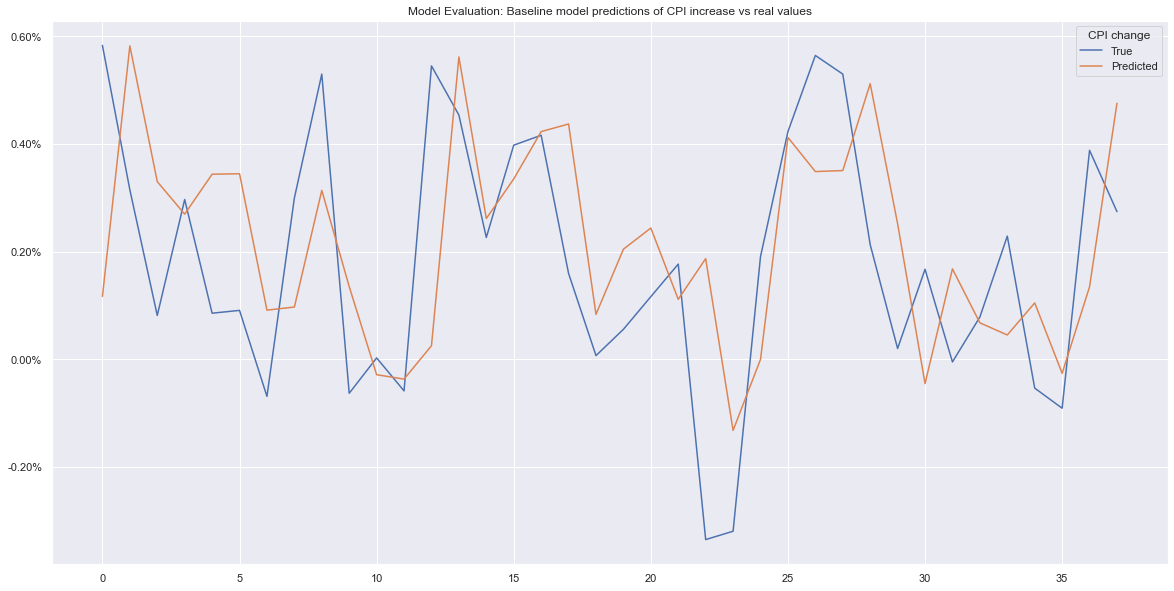

In [81]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_linreg)
plt.legend(labels=["True", "Predicted"], title = "CPI change")
plt.title('Model Evaluation: Baseline model predictions of CPI increase vs real values')
ylabels = ['{:,.2%}'.format(x) for x in plt.gca().get_yticks()]
plt.gca().set_yticklabels(ylabels)
plt.show()

### CatBoost

In [82]:
model_catboost = CatBoostRegressor()

In [83]:
model_catboost.fit(X_train, y_train, verbose=False)

In [84]:
model_catboost.score(X_test, y_test)

0.3371015676069261

In [85]:
y_pred_catboost = model_catboost.predict(X_test)

In [86]:
print('CatBoost results:')
print('-----------------')
print('RMSE: {:.2%}'.format(mean_squared_error(y_pred_catboost, y_test, squared=False)))

CatBoost results:
-----------------
RMSE: 0.19%


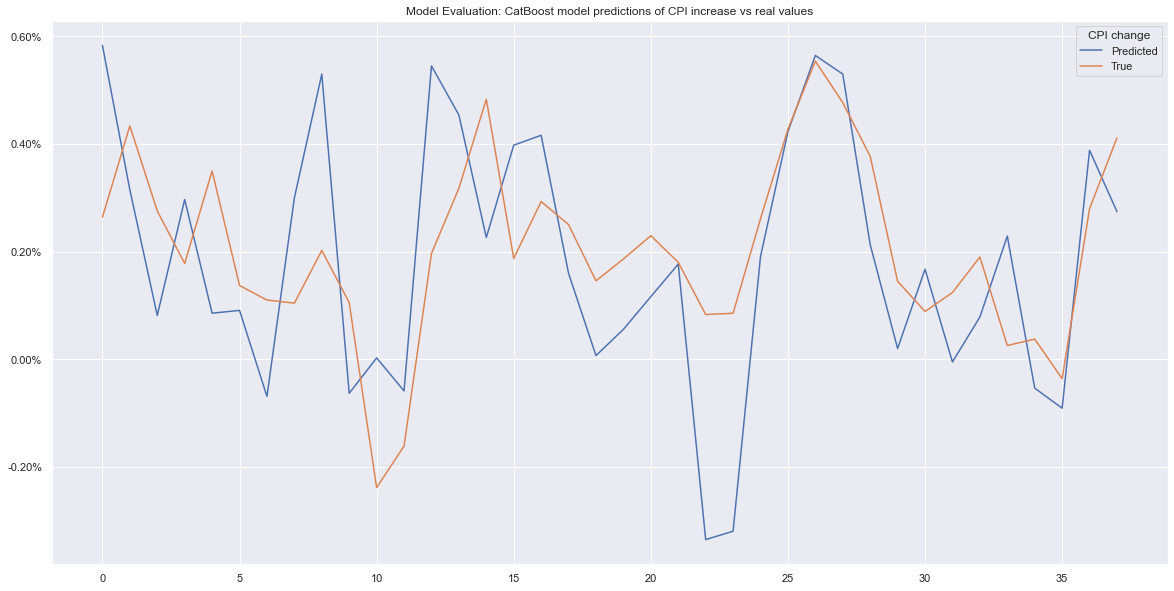

In [87]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_catboost)
plt.legend(labels=["Predicted","True"], title = "CPI change")
plt.title('Model Evaluation: CatBoost model predictions of CPI increase vs real values')
ylabels = ['{:,.2%}'.format(x) for x in plt.gca().get_yticks()]
plt.gca().set_yticklabels(ylabels)
plt.show()

<AxesSubplot:ylabel='0'>

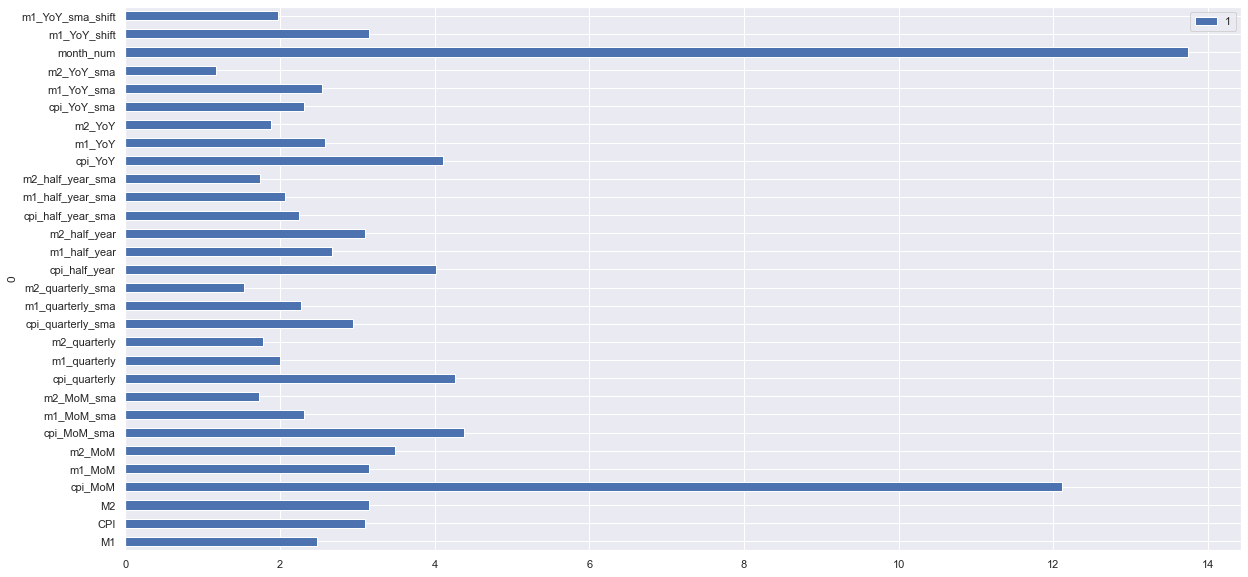

In [88]:
pd.DataFrame(zip(X_train.columns, model_catboost.get_feature_importance())).set_index(0).plot(kind='barh')